# Project tweetFinance

1. Financial Stock Market
2. Text Analysis on tweets (sentimental analysis)
3. Modeling
4. Prediction

---

## 1. Financial Data

In [143]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator

# pip install quandl
import quandl

plt.rcParams['figure.figsize'] = 12.0, 8.0

In [144]:
ticker = 'AAPL'
startDate = '2017-01-01'
endDate = '2017-11-05'

In [145]:
# quandl API_KEY
# modify api_key based on your own key
quandl.ApiConfig.api_key ="gw5WD-q5-b9vT2coXsL8"

data = quandl.get_table("WIKI/PRICES", qopts={'columns': ['ticker', 'date', 'volume', 'close']}, \
                                    ticker=[ticker], date={'gte': startDate, 'lte': endDate})

data.head(5)

,ticker,date,volume,close
None,,,,
0,AAPL,2017-01-03,28781865.0,116.15
1,AAPL,2017-01-04,21118116.0,116.02
2,AAPL,2017-01-05,22193587.0,116.61
3,AAPL,2017-01-06,31751900.0,117.91
4,AAPL,2017-01-09,33561948.0,118.99


In [146]:
# Unpack quotes

dates=data.date
close_v=data.close
volume=data.volume[1:]

# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

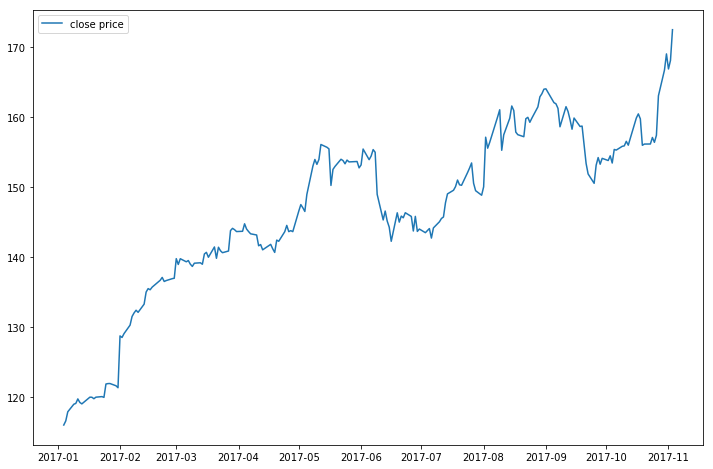

In [147]:
plt.plot(dates,close_v, label='close price'); plt.legend()
plt.show()

---
## 2. Fetch Twitter Data using API

In [148]:
import os
import sys
sys.path.insert(0, './tweetAnalysis/')

from analyzer import Analyzer
from termcolor import colored

In [149]:
sys.path[0]

'./tweetAnalysis/'

In [150]:
# Fill in twitter API_KEY and API_SECRET
# Here you need to modify based on your own api_key/api_secret
API_KEY = 'FJbEdD2966RobnHRcV6McpPDJ'
API_SECRET = 'YgbLxmT3q5KkP31gNKElnMG5LY3nAM0RgdkbJ4UY9rec4eoFcy'

In [151]:
import html

from twython import Twython
from twython import TwythonAuthError, TwythonError, TwythonRateLimitError

def get_user_timeline(screen_name, count=200):
    """Return list of most recent tweets posted by screen_name."""

    # ensure count is valid
    if count < 1 or count > 200:
        raise RuntimeError("invalid count")

    # ensure environment variables are set
    if not API_KEY:
        raise RuntimeError("API_KEY not set")
    if not API_SECRET:
        raise RuntimeError("API_SECRET not set")

    # get screen_name's (or @screen_name's) most recent tweets
    # https://dev.twitter.com/rest/reference/get/users/lookup
    # https://dev.twitter.com/rest/reference/get/statuses/user_timeline
    # https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py
    try:
        twitter = Twython(API_KEY, API_SECRET)
        user = twitter.lookup_user(screen_name=screen_name.lstrip("@"))
        if user[0]["protected"]:
            return None
        # probably you need more parameters
        # https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline

        tweets = twitter.get_user_timeline(screen_name=screen_name, count=count)
        return [html.unescape(tweet["text"].replace("\n", " ")) for tweet in tweets]
    except TwythonAuthError:
        raise RuntimeError("invalid API_KEY and/or API_SECRET") from None
    except TwythonRateLimitError:
        raise RuntimeError("you've hit a rate limit") from None
    except TwythonError:
        return None

In [152]:
def printTweet(user_name, numTweets):
    
    # get tweets
    # absolute paths to lists
    positives = os.path.join(sys.path[0], "positive-words.txt")
    negatives = os.path.join(sys.path[0], "negative-words.txt")
    
    # initialize Analyzer
    analyzer = Analyzer(positives, negatives)
    
    # get screen_name from argument of command line, ignore '@'
    screen_name=user_name.strip('@')
    
    # Query tweets from screen_name with Twitter API helpers.py
    # 10 resent tweets
    
    tweets = get_user_timeline(screen_name, numTweets)
    
    # check if successful
    if tweets == None:
        sys.exit("User is private or does not exist.")
    
    # analyze tweets
    # import code from ./tweetAnalysis/analyzer.py
    # basically, it's a sum up of frequency of positive/negative words
    # score > 0 means the sentence is more positive than negative
    # score < 0 indicates the sentence is more negative than positive
    # score = 0 means neutral
    
    for tweet in tweets:
        score = analyzer.analyze(tweet)
        
        # prints the score and tweet with color format
        
        if score >0: 
            # positive shows text in green color
            print(colored("{} {}".format(score, tweet), "green")) 
        elif score <0:
            # negative shows text in red color
            print(colored("{} {}".format(score, tweet), "red"))
        else:
            print(colored("{} {}".format(score, tweet), "yellow"))

In [153]:
userName='tim_cook'
printTweet(userName, 3)

-2 Shocked and sorrowed by the heartbreaking news from Texas. Prayers for all those touched by violence today: victims, survivors, worshippers.
3 To all my incredibly talented coworkers, congratulations on the launch of iPhone X! Thanks @WALKTHEMOONband for cel… https://t.co/HAATe3QfSz
0 iPhone X is here! A big thank-you to all our customers in Sydney, and everyone turning out around the world Friday!… https://t.co/CeWBakmWDg


---
## 3. Design Model

** Since we have a new parameter "score", there are many approaches to do **:
- Regression model
- Basic time-series model
...

### Need to clean up & organize data into a dataframe

In [154]:
# data export
def getTweet(userName, numTweets):
    
    screen_name=userName.strip('@')
    tweets = get_user_timeline(screen_name, numTweets)
    
    return tweets

In [155]:
def scoreTweet(tweet):
    positives = os.path.join(sys.path[0], "positive-words.txt")
    negatives = os.path.join(sys.path[0], "negative-words.txt")
    
    # initialize Analyzer
    analyzer = Analyzer(positives, negatives)

    if tweet == None:
        sys.exit("User is private or does not exist.")
    
    score = analyzer.analyze(tweet)
    return score

In [156]:
numTweets = 100
tweet = getTweet(userName, numTweets)
text = tweet
score = (list(map(scoreTweet, tweet)))

In [157]:
df = pd.DataFrame({'text':text, 'score':score})
df.head(10)

,score,text
0,-2,Shocked and sorrowed by the heartbreaking news...
1,3,"To all my incredibly talented coworkers, congr..."
2,0,iPhone X is here! A big thank-you to all our c...
3,0,Gotta wait til Friday! Meet me at the Apple St...
4,2,"Tonight our hearts are with the victims, their..."
5,2,"""If you love the life you live, live it every ..."
6,2,Thanks @ChicagosMayor for a great conversation...
7,1,"My kind of town, Chicago is 🎶 My kind of peopl..."
8,4,Happy #Diwali! May the festival of lights spre...
9,1,"To our friends, coworkers and all those in the..."


In [158]:
pwd = os.getcwd()
pwd

'F:\\Git\\tweetFinance'

In [159]:
# export a csv file in notebook folder
df.to_csv('tweetData.csv')